# Here are some post processing codes for the cases with Navier-Stokes solver

- [2-Poiseuille-flow-Newtonian.c](../testCases/2-Poiseuille-flow-Newtonian.c)
- [2-Poiseuille-flow-Bingham.c](../testCases/2-Poiseuille-flow-Bingham.c)
- [2-2D_rot_cylinder.c](../testCases/2-2D_rot_cylinder.c)
- [2-LidDrivenCavity-Newtonian.c](../testCases/2-LidDrivenCavity-Newtonian.c)

## Post processing code for 2-2D_rot_cylinder.c


In [1]:
import numpy as np
import os
import subprocess as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import StrMethodFormatter
import multiprocessing as mp
from functools import partial
import argparse  # Add at top with other imports
import sys

import matplotlib.colors as mcolors
custom_colors = ["white", "#DA8A67", "#A0522D", "#400000"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_hot", custom_colors)

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

def gettingfield(filename, zmin, zmax, rmin, rmax, nr):
    exe = ["./getData-generic", filename, str(zmin), str(rmin), str(zmax), str(rmax), str(nr)]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    # print(temp2) #debugging
    Rtemp, Ztemp, Ttemp, cstemp  = [],[],[],[]

    for n1 in range(len(temp2)):
        temp3 = temp2[n1].split(" ")
        if temp3 == ['']:
            pass
        else:
            Ztemp.append(float(temp3[0]))
            Rtemp.append(float(temp3[1]))
            Ttemp.append(float(temp3[3]))
            cstemp.append(float(temp3[2]))

    R = np.asarray(Rtemp)
    Z = np.asarray(Ztemp)
    T = np.asarray(Ttemp)
    cs = np.asarray(cstemp)
    nz = int(len(Z)/nr)

    # print("nr is %d %d" % (nr, len(R))) # debugging
    print("nz is %d" % nz)

    R.resize((nz, nr))
    Z.resize((nz, nr))
    T.resize((nz, nr))
    cs.resize((nz, nr))

    # rotate by 270 degrees
    R = np.rot90(R, k=1)
    Z = np.rot90(Z, k=1)
    T = np.rot90(T, k=1)
    cs = np.rot90(cs, k=1)
    # flip the array
    R = np.flip(R, axis=0)
    Z = np.flip(Z, axis=0)
    T = np.flip(T, axis=0)
    cs = np.flip(cs, axis=0)

    return R, Z, T, cs, nz
# ----------------------------------------------------------------------------------------------------------------------

def process_timestep(caseToProcess, folder, GridsPerR, rmin, rmax, zmin, zmax, lw):
    place = f"{caseToProcess}"
    name = f"{folder}/2-2D_rot_cylinder.png"

    if not os.path.exists(folder):
        os.makedirs(folder)

    if not os.path.exists(place):
        print(f"{place} File not found!")
        return
    
    nr = int(GridsPerR * rmax)
    R, Z, T, cs, nz = gettingfield(place, zmin, zmax, rmin, rmax, nr)
    zminp, zmaxp, rminp, rmaxp = Z.min(), Z.max(), R.min(), R.max()

    # Plotting
    AxesLabel, TickLabel = 50, 20
    fig, ax = plt.subplots()
    fig.set_size_inches(19.20, 10.80)

    ax.plot([0, 0], [zmin, zmax], '-.', color='grey', linewidth=lw)
    ax.plot([-rmax, -rmax], [zmin, zmax], '-', color='black', linewidth=lw)
    ax.plot([-rmax, rmax], [zmin, zmin], '-', color='black', linewidth=lw)
    ax.plot([-rmax, rmax], [zmax, zmax], '-', color='black', linewidth=lw)
    ax.plot([rmax, rmax], [zmin, zmax], '-', color='black', linewidth=lw)

    cntrl1 = ax.imshow(T, cmap="coolwarm", interpolation='Bilinear', origin='lower', extent=[rminp, rmaxp, zminp, zmaxp], vmax=1.0, vmin=0.0)

    # Draw two concentric circles centered at (0,0)
    # Based on the testCases/1-conduction-2D-annulus, we need inner and outer circles
    
    # Get inner and outer radii from the test case
    # Typically these would be defined as INNER_RADIUS and OUTER_RADIUS
    inner_radius = 1.0  # Default value, should match INNER_RADIUS in the test case
    outer_radius = 1.5  # Default value, should match OUTER_RADIUS in the test case
    # Clip the temperature field to the outer circle region so that data outside is not displayed
    outer_circle = plt.Circle((0, 0), outer_radius, transform=ax.transData)
    cntrl1.set_clip_path(outer_circle)
    # Create a white circle for the inner region (this is already working)
    inner_circle = plt.Circle((0, 0), inner_radius, fill=True, color='white', linestyle='-', linewidth=lw)
    ax.add_patch(inner_circle)

    ax.set_aspect('equal')
    ax.set_xlim(rmin, rmax)
    ax.set_ylim(zmin, zmax)

    l, b, w, h = ax.get_position().bounds
    # Left colorbar
    cb1 = fig.add_axes([l-0.04, b, 0.03, h])
    c1 = plt.colorbar(cntrl1, cax=cb1, orientation='vertical')
    c1.set_label(r'$\|u_i\|$', fontsize=TickLabel, labelpad=5)
    c1.ax.tick_params(labelsize=TickLabel)
    c1.ax.yaxis.set_ticks_position('left')
    c1.ax.yaxis.set_label_position('left')
    c1.ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    ax.axis('off')
    # Set figure background to white for saving
    fig.patch.set_facecolor('white')
    plt.savefig(name, bbox_inches="tight", facecolor='white')
    plt.show()

nz is 768


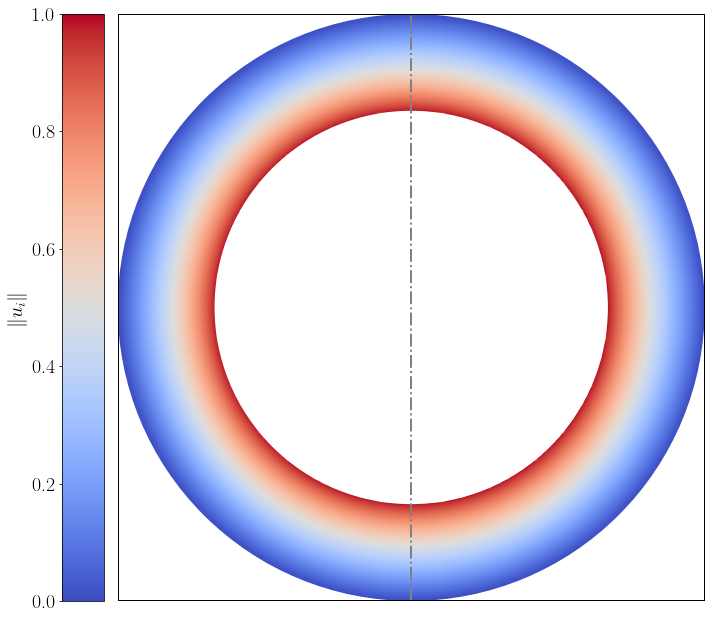

In [2]:
process_timestep(caseToProcess="../testCases/2-2D_rot_cylinder/restart",
                             folder="img",
                             GridsPerR=512, rmin=-1.5, rmax=1.5, 
                             zmin=-1.5, zmax=1.5, lw=2)